In [1]:
import import_ipynb #Allows you to import ipynb files
import numpy as np
from vehicle import *
from Grid import Grid
from utils import *

importing Jupyter notebook from vehicle.ipynb
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from Grid.ipynb
importing Jupyter notebook from GVD.ipynb


In [20]:
class PathSmoother:
    """Will take a path list and use gradient descent to smooth it out"""
    #smoothing based on http://ai.stanford.edu/~ddolgov/papers/dolgov_gpp_stair08.pdf
    def __init__(self):
        #Used in gradient descent
        self._tolerance = 0.001
        self._maxIterations = 2000
        self._alpha = 0.2
        
        #Weights
        self._wPath = 0.0
        self._wSmooth = 4     
        self._wCollision = 0.002
        self._wCurvature = 4.0
        self._wVoronoi = 0.2
        
        self._collisionDmax = 5.0
        self._voronoiDmax = 20.0
        self._kMax = 1
        
    #path == states
    def smooth(self, path, grid):
        voro = grid.returnVoroDistanceMap()
        obst = grid.returnDistanceMap()
        if(len(path) < 5):
            return path
        
        currentPath = []
        for segment in path:
            currentPath.append(segment)
        
        count = 0
        change = self._tolerance
        while(count < self._maxIterations):
            for i in range(2, len(path)-2):
                if (currentPath[i - 2].gear != currentPath[i - 1].gear): continue
                if (currentPath[i - 1].gear != currentPath[i].gear): continue
                if (currentPath[i].gear != currentPath[i + 1].gear): continue
                if (currentPath[i + 1].gear != currentPath[i + 2].gear): continue
                
                currentPosition = currentPath[i].position
                correction = (0,0)
                if(IsPointInGrid(currentPosition, (grid.width, grid.height))):
                    x = int(np.floor(currentPosition[0]))
                    y = int(np.floor(currentPosition[1]))
                    
                    #OBST
                    closestObstVec = tuple(np.subtract(currentPosition, obst[x][y])) #xi - oi
                    obstDist = closestObstVec[0]**2 + closestObstVec[1]**2 #|xi - oi|
                    if(obstDist <= self._collisionDmax):
                        mult = self._wCollision * 2 * (obstDist - self._collisionDmax) / obstDist
                        correction = tuple(np.subtract(correction, tuple(np.multiply(closestObstVec, (mult,)))))
                    
                    #VORONOI LOOK INTO THIS LATER
                    if(obstDist < self._voronoiDmax and self._wVoronoi > 0):
                        alphaplusdo = 20 + obstDist
                        closestVoroVec = tuple(np.subtract(currentPosition, voro[x][y])) #xi - oi
                        voroDist = closestVoroVec[0]**2 + closestVoroVec[1]**2 #|xi - oi|
                        dominusdmax = obstDist - voroDist
                        doplusdv = obstDist + voroDist
                        dmaxsquared = self._voronoiDmax * self._voronoiDmax
                        pvdv = (20/alphaplusdo)*(dominusdmax * dominusdmax / dmaxsquared) * (obstDist / (doplusdv * doplusdv))
                        pvdo = (voroDist / doplusdv) * (dominusdmax / dmaxsquared) * (-dominusdmax / alphaplusdo - dominusdmax / doplusdv + 2)
                        if(voroDist > 0):
                            one = tuple([i * pvdo/obstDist for i in closestObstVec])
                            two = tuple([i * pvdv/voroDist for i in closestObstVec])
                            three = tuple(np.add(one,two))
                            correction = tuple(np.subtract(correction,tuple([self._wVoronoi * i for i in three])))
                        
                #SMOOTH
                var1 = currentPath[i-2].position
                var2 = tuple([4*i for i in currentPath[i-1].position])
                var3 = tuple([6*i for i in currentPosition])
                var4 = tuple([4*i for i in currentPath[i+1].position])
                var5 = currentPath[i+2].position
                smoothX = self._wSmooth * (var1[0] - var2[0] + var3[0] - var4[0] + var5[0])
                smoothY = self._wSmooth * (var1[1] - var2[1] + var3[1] - var4[1] + var5[1])
                correction = tuple(np.subtract(correction, (smoothX, smoothY)))
                #CURVE
                curve = self.curvatureTerm(currentPath[i-1].position, currentPosition, currentPath[i+1].position)
                #correction = tuple(np.subtract(correction, tuple([i*self._wCurvature for i in curve])))
    
                norm = self._wPath + self._wSmooth + self._wCollision + self._wCurvature + self._wVoronoi
                correction = tuple([i / norm for i in correction])
                currentPath[i].position = tuple(np.add(currentPosition,tuple([z * self._alpha for z in correction])))
                change += correction[0]**2 + correction[1]**2
            count += 1
            
        smoothPath = []
        
        for segment in currentPath:
            smoothPath.append(segment)
            
        return smoothPath
    def curvatureTerm(self, xim1, xi, xip1):
        dxi = (xi[0] - xim1[0], xi[1] - xim1[1])
        distdxi = dxi[0]**2 + dxi[1]**2
        dxiPlusOne = (xip1[0] - xi[0], xip1[1] - xi[1])
        distdxiPlusOne = dxiPlusOne[0]**2 + dxiPlusOne[1]**2
        dphi = np.arccos((dxi[0]*dxiPlusOne[0] + dxi[1]*dxiPlusOne[1])/(distdxi + distdxiPlusOne))
        if(distdxi == 0):
            return (0,0)
        k = dphi / distdxi
        if(k <= self._kMax):
            return (0,0)
        
        ddphi = (-1/np.sqrt(1-np.cos(dphi)**2))
        denom = (xi[0]**2 + xi[1]**2) * (xip1[0]**2 + xip1[1]**2)
        
        xip1neg = (xip1[0]*-1, xip1[1]*-1)
        p1 = self.perp(xi, xip1neg)
        p2 = self.perp(xip1neg,xi)
        
        coeff1 = -1/distdxi * ddphi
        coeff2 = dphi / distdxi**2
        
        ki = tuple([.5 * (coeff1*(-1*p1[i] - p2[i]) - coeff2*-1) for i,_ in enumerate(p1)])
        kim1 = tuple([.25 * (coeff1*i - coeff2*-1) for i in p2])
        kip1 =  tuple([.25 * coeff1 * i for i in p1])
        kfinal = k - self._kMax
        ktuple = tuple(np.add(ki, kim1))
        ktuple = tuple(np.add(ktuple, kip1))
        return tuple([kfinal * i for i in ktuple])
    
    def perp(self, a, b):
        dot = (a[0] * b[0] + a[1] * b[1])/(b[0]**2 + b[1]**2)
        bd = tuple([i * dot for i in b])
        return tuple([a[i] - bd[i] for i,_ in enumerate(a)])

In [21]:
from HybridAStar import HybridAStar

In [22]:
v = Vehicle((1,1))
rows, cols = 31, 31
g = Grid(rows, cols)
obstacle_list = [(0,0), (30,30), (15,15), (0,30), (30,0), (15,0), (0,15), (30,15), (15,30), (1,15),
                (2,15), (3,15),(4,15),(5,15),(6,15),(7,15),(8,15),(9,15),(10,15),(11,15),(12,15),(13,15),(14,15),
                (15,14),(15,13),(15,12),(15,11),(15,10)]
[g.AddObstacle(obs) for obs in obstacle_list]
obs_X = [cell[0] for cell in g.obstacleCells]
obs_Y = [cell[1] for cell in g.obstacleCells]

start = VehicleState((29,24),np.deg2rad(180))
end = VehicleState((4,4),np.deg2rad(135))

hastar = HybridAStar(g, v)
path, states = hastar.run(start,end)

path_X = [cell[0] for cell in path] 
path_Y = [cell[1] for cell in path]

state_X = [state.position[0] for state in states] 
state_Y = [state.position[1] for state in states]
state_O = [state.orientation for state in states]

In [23]:
ps = PathSmoother()
smoothPath = ps.smooth(states, g)
smoothPath_X = [state.position[0] for state in smoothPath] 
smoothPath_Y = [state.position[1] for state in smoothPath]
smoothPath_O = [state.orientation for state in smoothPath]

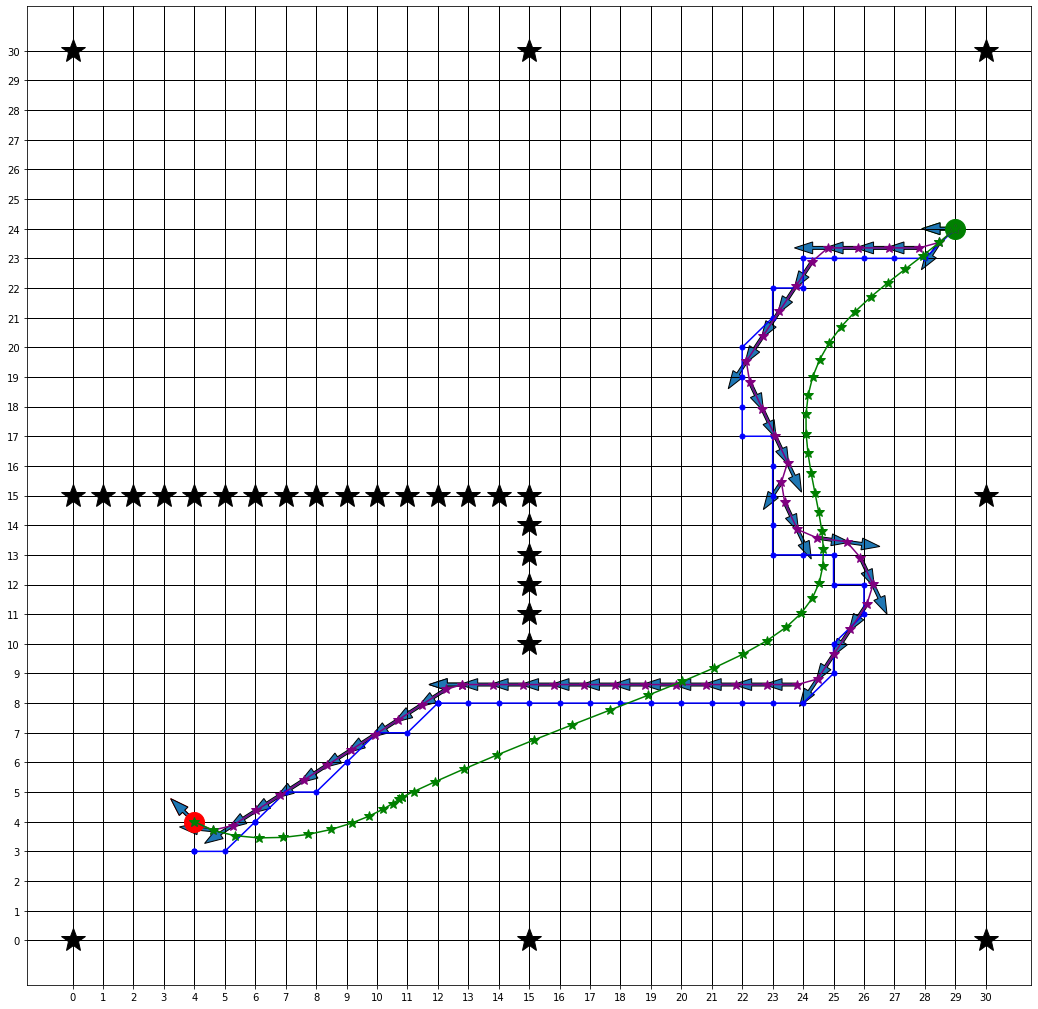

In [24]:
import matplotlib.pyplot as plt
#PRINTER
#colormap
#cmap = colors.ListedColormap(['white', 'black'])
#bounds = [0,.5,1]
#norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
#x.imshow(data,extent=[0, rows, 0, cols], cmap=cmap, norm=norm)
ax.plot(start.position[0], start.position[1], marker='.', color='green', linestyle='none', MarkerSize=40)
x, y, a, b = start.position[0], start.position[1], 1, np.rad2deg(start.orientation)
x1, y1 = rpoint(x,y,a,b)
plt.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .4, width = .1,color='green')
ax.plot(end.position[0], end.position[1], marker='.', color='red', linestyle='none', MarkerSize=40)
x, y, a, b = end.position[0], end.position[1], 1, np.rad2deg(end.orientation)
x1, y1 = rpoint(x,y,a,b)
plt.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .4, width = .1,color='red')

ax.plot(path_X, path_Y, marker='.', color='blue', MarkerSize=10)
ax.plot(state_X, state_Y, marker='*', color='purple', MarkerSize=10)
ax.plot(smoothPath_X, smoothPath_Y, marker='*', color='green', MarkerSize=10)
ax.plot(obs_X, obs_Y, marker='*', color='black', MarkerSize=25, linestyle='none')
#draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_xticks(np.arange(0, rows, 1))
ax.set_yticks(np.arange(0, cols, 1))
# for index in range(len(smoothPath_O)):
#     x, y, a, b = smoothPath_X[index], smoothPath_Y[index], 1, np.rad2deg(smoothPath_O[index])
#     x1, y1 = rpoint(x,y,a,b)
#     plt.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .4, width = .1,)
for index in range(len(state_O)):
    x, y, a, b = state_X[index], state_Y[index], 1, np.rad2deg(state_O[index])
    x1, y1 = rpoint(x,y,a,b)
    plt.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .4, width = .1,)
plt.rcParams['figure.figsize'] = [18, 18]
plt.show()